In [1]:
# Uncomment if use Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive


Mounted at /content/gdrive


In [2]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F


In [3]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)

# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

In [4]:
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/AI/CW/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 2 # i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']

# Task 1: Creating the training dataset and dataloader

There are 2000 functions in the training dataset. From the training dataset, 80% of the data will be used to train the model with 20% held out as a validation set.

In [5]:
# Train-test split point
n_train = int(0.8*2000)

# Dataset object
train_dataset = data.TensorDataset(x[:n_train], y[:n_train])
val_dataset = data.TensorDataset(x[n_train:], y[n_train:])

# Batch size
batch_size= 64

# DataLoader object
train_data_iter = data.DataLoader(train_dataset, batch_size, shuffle=True)
val_data_iter = data.DataLoader(val_dataset, batch_size, shuffle=True)


# Task 2: Creating the Encoder and Decoder classes

Two classes were made for the encoder and decoder.

## Encoder class

The Encoder is a MLP with 2 hidden layers. The inputs to the encoder are the context points, x_c and y_c with the number of outputs, $ r_{dim} $, chosen to be 2 initially.

In [6]:
class Encoder(torch.nn.Module):
  def __init__(self, num_inputs, hidden_layer1, hidden_layer2, num_outputs):
    super(Encoder, self).__init__()

    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.hidden_layer1 = hidden_layer1 
    self.hidden_layer2 = hidden_layer2
    self.Linear1 = nn.Linear(num_inputs, hidden_layer1)
    self.Linear2 = nn.Linear(hidden_layer1, hidden_layer2)
    self.Linear3 = nn.Linear(hidden_layer2, num_outputs)

  def forward(self, x):
    x1 = F.relu(self.Linear1(x)) 
    x2 = F.relu(self.Linear2(x1)) 
    x3 = self.Linear3(x2)
    return x3


## Decoder class

The Decoder is a MLP with 2 hidden layers. The inputs to the decoder is the r_C values generated from the encoder and the x_t values. 

In [7]:
class Decoder(torch.nn.Module):
  def __init__(self, num_inputs, hidden_layer1, hidden_layer2, num_outputs):
    super(Decoder, self).__init__()
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.hidden_layer1 = hidden_layer1
    self.hidden_layer2 = hidden_layer2
    self.Linear1 = nn.Linear(num_inputs, hidden_layer1)
    self.Linear2 = nn.Linear(hidden_layer1, hidden_layer2)
    self.Linear3 = nn.Linear(hidden_layer2, num_outputs)
 
  def forward(self, x):
    x1 = F.relu(self.Linear1(x))
    x2 = F.relu(self.Linear2(x1))
    x3 = self.Linear3(x2)
    return x3


In [8]:
# Number of dimensions of the output
r_dim = 2

# numbers of inputs, hidden layers and outputs.
num_inputs, hidden_layer1, hidden_layer2, num_outputs = 2, 20, 20, r_dim

# instantiating the encoder & decoder
encoder = Encoder(num_inputs, hidden_layer1, hidden_layer2, num_outputs)
decoder = Decoder(r_dim+1, hidden_layer1, hidden_layer2, 1)

# Task 3: Optimizer and the loss



### Initialisation of weights for the Encoder and Decoder


In [9]:
# initialise weights for both encoder & decoder
def init_weights(m):
    if isinstance(m, nn.Linear): 
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

encoder.apply(init_weights)
decoder.apply(init_weights)

Decoder(
  (Linear1): Linear(in_features=3, out_features=20, bias=True)
  (Linear2): Linear(in_features=20, out_features=20, bias=True)
  (Linear3): Linear(in_features=20, out_features=1, bias=True)
)

### Loss, weight decay and optimizer 
A loss of 0.01 was selected, with zero weight decay in this version of the model. The optimizer chosen was Adam as SGD performed poorly.

In [10]:
# Mean Squared Loss
loss = nn.MSELoss() 

# Loss and weight decay
lr, wd = 0.01, 0


encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=wd)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr, weight_decay=wd)

# Task 4: Training the model

The model was trained using the training dataset with 1000 epochs. The training loss across each epoch is returned and is plotted below.

In [11]:
def train(encoder, decoder, train_iter, loss, encoder_optimizer, decoder_optimizer, epochs):
  training_loss_list = []
  epoch_count = 0
  for epoch in range(epochs):
    epoch_count+=1
    loss_score = 0.0

    for X,y in train_iter:

      # number of context points
      num_of_contexts = random.randint(5,35)

      # indices of context points
      c_idxs = random.sample(range(0,40), num_of_contexts)

      # Empty tensors for the context points
      x_contexts = torch.empty(len(X), num_of_contexts)
      y_contexts = torch.empty(len(X), num_of_contexts)

      # putting the context points into tensors
      for i in range(len(X)):
        x_np_vals = np.take(X[i].numpy(),c_idxs)
        y_np_vals = np.take(y[i].numpy(),c_idxs)
        x_vals = torch.from_numpy(x_np_vals)
        y_vals = torch.from_numpy(y_np_vals)
        x_contexts[i,:] = x_vals
        y_contexts[i,:] = y_vals

      # context_feats returns tensor in shape torch.Size([batch_size, num_of_contexts, 2])
      context_feats = torch.stack([x_contexts, y_contexts], dim=2)
      # print(f'context_feats.shape: {context_feats.shape}')

      # r_c values from the encoder
      r_c = encoder(context_feats)

      # Mean of r_c values 
      r_C_mean = torch.mean(r_c,1)

      # changing the shape of the tensor
      r_C_unsq = r_C_mean.unsqueeze(1)
      r_C = r_C_unsq.repeat((1,40,1))

      # joining the r_C and X tensors as the input to the decoder
      dec_input = torch.cat((r_C,X),2)

      # Calculation of predicted y values
      y_hat = decoder(dec_input)

      # loss calculation
      l = loss(y_hat,y)

      # gradients set to zero
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      # weights are updated
      l.backward()

      # Parameters are updated using current gradients
      encoder_optimizer.step()
      decoder_optimizer.step()

      # training loss is added
      loss_score += l
    
    # average training loss score is calculated
    train_loss = loss_score/len(train_iter)

    # training loss for each epoch is added
    training_loss_list.append(train_loss.detach().numpy())
    if epoch_count % 100 ==0: 
      print(f'Epoch: {epoch_count}, loss: {train_loss:.5f}')
  return np.asarray(training_loss_list)

In [12]:
model = train(encoder, decoder, train_data_iter, loss, encoder_optimizer,decoder_optimizer, 1000)

# Average training loss over the last 50 epochs.
train_loss_avg = np.mean(model[-50:])
print(f'Training loss over the last 50 epochs: {train_loss_avg:0.5f}')

Epoch: 100, loss: 0.02512
Epoch: 200, loss: 0.01340
Epoch: 300, loss: 0.01452
Epoch: 400, loss: 0.00997
Epoch: 500, loss: 0.01259
Epoch: 600, loss: 0.00566
Epoch: 700, loss: 0.00619
Epoch: 800, loss: 0.01919
Epoch: 900, loss: 0.01050
Epoch: 1000, loss: 0.01091
Training loss over the last 50 epochs: 0.00899


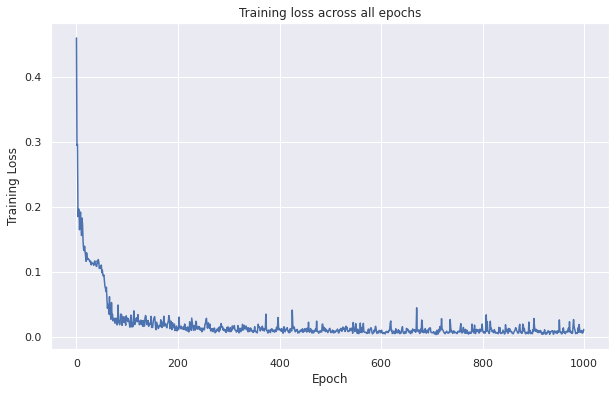

In [13]:
sns.set()
plt.figure(figsize=(10,6))
plt.plot(np.arange(1000), model)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training loss across all epochs')
plt.xlim(left=-50);

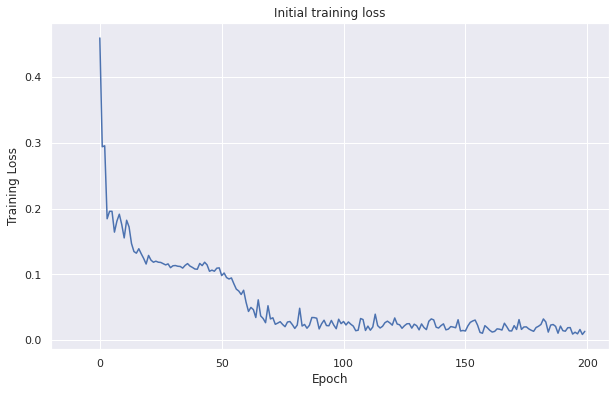

In [14]:
sns.set()
plt.figure(figsize=(10,6))
plt.plot(np.arange(200), model[:200])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Initial training loss')
plt.xlim(left=-20);

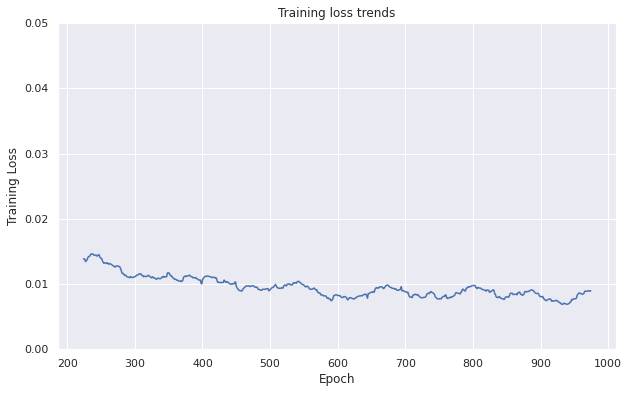

In [15]:
def moving_average(epoch_loss, window):
    return np.convolve(epoch_loss, np.ones(window), 'valid') / window

sns.set()
plt.figure(figsize=(10,6))
plt.plot(np.arange(224,975), moving_average(model[200:], 50))

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training loss trends')
plt.ylim(bottom=0,top=0.05);

# Validating the model
With the model trained, data from from the validation dataset is passed to the model.

In [16]:
def validation_score(encoder, decoder, val_iter, val_c_idxs, loss, encoder_optimizer, decoder_optimizer):
  validation_loss = 0.0

  with torch.no_grad():
    for X,y in val_iter:

      # indices of context points
      c_idxs = val_c_idxs
      num_of_contexts = len(val_c_idxs)

      # Empty tensors for the context points
      x_contexts = torch.empty(len(X), num_of_contexts)
      y_contexts = torch.empty(len(X), num_of_contexts)

      for i in range(len(X)):
        x_np_vals = np.take(X[i].numpy(),c_idxs)
        y_np_vals = np.take(y[i].numpy(),c_idxs)
        x_vals = torch.from_numpy(x_np_vals)
        y_vals = torch.from_numpy(y_np_vals)
        x_contexts[i,:] = x_vals
        y_contexts[i,:] = y_vals

      context_feats = torch.stack([x_contexts, y_contexts], dim=2)

      # r_c values from the encoder
      r_c = encoder(context_feats)

      # Mean of r_c values 
      r_C_mean = torch.mean(r_c,1)

      # Changing tensor dimensions 
      r_C_unsq = r_C_mean.unsqueeze(1)
      r_C = r_C_unsq.repeat((1,40,1))

      # joining the r_C and X tensors as the input to the decoder
      decoder_input = torch.cat((r_C,X),2)

      # Calculation of predicted y values
      y_hat = decoder(decoder_input)
      
      # loss calculation
      l = loss(y_hat,y)

      validation_loss += l
  val_loss = validation_loss/len(val_iter)

  return val_loss

In [17]:
def create_val_c_idxs(number_of_samples):
  """ Function that creates lists of random indices of the context points used in validation"""
  val_c_idxs = []
  for sample in range(number_of_samples):
    num_of_contexts = random.randint(5,35)
    c_idxs = random.sample(range(0,40), num_of_contexts)
    val_c_idxs.append(c_idxs)
  return val_c_idxs

def val_score_mean(idxs_list):
  """Function that returns the average of the validation scores from different context indices"""
  val_score_list = []
  for i in range(len(idxs_list)):
    sample_score = validation_score(encoder, decoder, val_data_iter, idxs_list[i], loss, encoder_optimizer, decoder_optimizer)
    sample_score = sample_score.detach().numpy()
    val_score_list.append(sample_score)
  mean_score = np.mean(np.asarray(val_score_list))
  return mean_score

# 500 different lists indices are generated
idxs_list = create_val_c_idxs(500)

# Mean of the validation scores
mean_score = val_score_mean(idxs_list)
print(f'Average validation training loss: {mean_score:0.5f}')


Average validation training loss: 0.00673


# Testing the model

With the model trained and validated, unseen test data is processed and generated.

In [18]:
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/AI/CW/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))

i = 1
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']



In [19]:
# reshaping the context points
x_c = x_c.view(-1)
y_c = y_c.view(-1)

# creating the context pairs as input to the encoder
context_pairs = torch.stack([x_c, y_c], dim=1)

# reshaping the x_t values for the decoder
x_t = x_t.resize_((40,1))

# r_c output from the encoder
r_c = encoder(context_pairs)

# mean of r_c values 
r_C_mean = torch.mean(r_c,0)

# changing tensor dimensions
r_C = r_C_mean.repeat([40,1])

# input to the decoder
dec_input = torch.cat([r_C, x_t], 1)

# predicted y values
y_preds = decoder(dec_input)

# x and y values as arrays
y_preds = y_preds.squeeze().detach().numpy()
x_t_array = x_t.squeeze().detach().numpy()

# context points as arrays
x_c_array = x_c.detach().numpy()
y_c_array = y_c.detach().numpy()

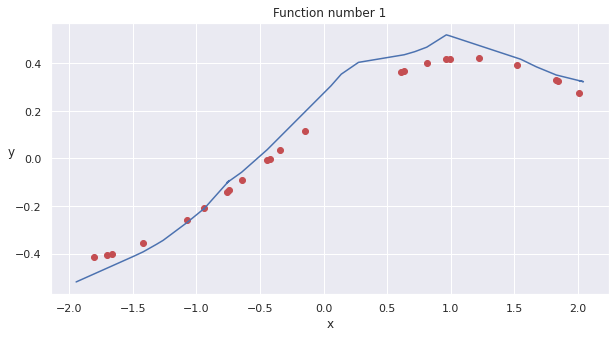

In [20]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(x_t_array, y_preds)

plt.scatter(x_c_array,y_c_array, c='r')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title(f'Function number {i}');